# Instalación

In [ ]:
!pip install langchain==0.3.0 \
             langchain-core==0.3.0 \
             langchain-community==0.3.0 \
             langchain-text-splitters==0.3.0 \
             langchain-google-genai \
             pydantic==2.9.0 \
             --no-cache-dir

!pip install llama-index-core \
             llama-index-llms-google-genai \
             llama-index-embeddings-huggingface \
             llama-index-retrievers-bm25 \
             --no-cache-dir

!pip install google-generativeai chromadb rank_bm25 pandas neo4j matplotlib seaborn scikit-learn gdown unidecode ollama sentence-transformers nest_asyncio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.9/146.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.3/434.3 kB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.5 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.41.5
    Uninstalling pydantic_core-2.41.5:
      Successfully uninstalled pydantic_core-2.41.5
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.12.5
    Uninstalling pydantic-2.12.5:
      Successfully uninstalled pydantic-2.12.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-index-instrumentation 0.4.2 requires pydantic>=2.11.5, but you have pydantic 2.9.0 which is incompatible.
llama-index-workflows 2.11.5 requires pydantic>=2.11.5, but you have pydantic 2.9.0 which is incompatible.
google-adk 1.21.0 req

In [ ]:
import os
import json
import time
import random
import re
from collections import deque
from typing import List, Dict, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import gdown
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

# Embeddings y modelos de texto
import nltk
from nltk.tokenize import word_tokenize
from unidecode import unidecode
from sentence_transformers import SentenceTransformer, CrossEncoder
from rank_bm25 import BM25Okapi

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report)

# Bases de datos y almacenamiento vectorial
import chromadb
from neo4j import GraphDatabase
from chromadb import Client

# LlamaIndex y LangChain (RAG, retrieval, agentes)
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.agents import AgentExecutor, create_react_agent
from langchain.prompts import PromptTemplate
from langchain_core.prompts import PromptTemplate as CorePromptTemplate
from langchain.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, Document
from llama_index.core.settings import Settings
from llama_index.core.schema import TextNode, NodeWithScore, QueryBundle
from llama_index.core.retrievers import VectorIndexRetriever, QueryFusionRetriever
from llama_index.core.postprocessor import SentenceTransformerRerank
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.google_genai import GoogleGenAI

# Google Generative AI y async
import google.generativeai as genai
import nest_asyncio

In [ ]:
nest_asyncio.apply()

# Keys

In [ ]:
# Key de OpenAI
os.environ["OPENAI_API_KEY"] = ""

# Key de Google
os.environ["GOOGLE_API_KEY"] = ""

# Key de Neo4j
NEO4J_URI = os.getenv("NEO4J_URI", "")
NEO4J_USER = os.getenv("NEO4J_USER", "")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "")

# Carga de fuente de datos

In [ ]:
# Se descarga y descomprime la carpeta con los archivos
!gdown --id 13gmIF7MT0Wkio1DO3PDTAxNNqaKdpXFk
!unzip -q '/content/Fuentes-NLP.zip' -d '/content/'

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=13gmIF7MT0Wkio1DO3PDTAxNNqaKdpXFk
To: /content/Fuentes-NLP.zip
100% 2.31M/2.31M [00:00<00:00, 239MB/s]


In [ ]:
# Obtenemos los archivos
!unzip -q '/content/manuales_productos-20251125T015006Z-1-001.zip' -d '/content/'
!unzip -q '/content/resenas_usuarios-20251125T015004Z-1-001.zip' -d '/content/'

# Se crean dataframes
df_devoluciones = pd.read_csv('devoluciones.csv')
df_productos = pd.read_csv('productos.csv')
df_tickets_soporte = pd.read_csv('tickets_soporte.csv')
df_vendedores = pd.read_csv('vendedores.csv')
df_ventas_historicas = pd.read_csv('ventas_historicas.csv')
df_inventario_sucursales = pd.read_csv('inventario_sucursales.csv')

In [ ]:
df_productos.head()

,id_producto,nombre,categoria,subcategoria,marca,precio_usd,stock,color,potencia_w,capacidad,voltaje,peso_kg,garantia_meses,descripcion
0,P0001,Licuadora,Cocina,Preparación,TechHome,283.63,108,Blanco,650.0,1.2L,12V,5.6,36,"Descubrí el poder de la Licuadora de TechHome,..."
1,P0002,Licuadora,Cocina,Preparación,TechHome,1273.06,114,Rosa,300.0,2.0L,220V,35.9,36,"Descubrí el poder de la Licuadora de TechHome,..."
2,P0003,Plus Licuadora Pro,Cocina,Preparación,TechHome,329.07,97,Negro,700.0,1.2L,220V,47.9,18,Descubrí el poder de la Plus Licuadora Pro de ...
3,P0004,Compacto Licuadora,Cocina,Preparación,ChefMaster,259.42,75,Rosa,1000.0,2.0L,220V,48.7,24,Descubrí el poder de la Compacto Licuadora de ...
4,P0005,Licuadora,Cocina,Preparación,HomeChef,2602.78,97,Azul,1350.0,1.2L,110-220V,49.3,12,"Descubrí el poder de la Licuadora de HomeChef,..."


# Modelos

**Embedding**

In [ ]:
# Definimos el modelo de embedding y su función para utlizarlo
embed_model = SentenceTransformer("intfloat/multilingual-e5-small")
Settings.embed_model = HuggingFaceEmbedding(model_name="intfloat/multilingual-e5-small")

def embed(texts):
    return embed_model.encode(texts, normalize_embeddings=True).tolist()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Como modelo de embedding se seleccionó multilingual-e5-small. Este modelo de embedding al estar optimizado para capturar la similitud semántica entre consultas y documentos, fue mantenido a lo largo de todo el TP, ofreciendo un equilibrio entre calidad semántica y eficiencia. Además, es un modelo con soporte multilingüe, que es capaz de representar textos en distintos idiomas dentro de un mismo espacio vectorial, que si bien no es el caso, agrega robustez a nuestro trabajo final.

**LLM**

In [ ]:
# Definimos el modelo LLM
model = GoogleGenAI("models/gemini-2.0-flash")
Settings.llm = model

Como modelo de lenguaje se seleccionó Gemini 2.0 Flash, ya que esta versión nos ofrece un equilibrio entre calidad de respuestas y rendimiento. La versión Flash está optimizada para ofrecer baja latencia y un alto número de consultas por segundo, lo que resulta adecuado para el enfoque del TP.

Durante el desarrollo se evaluaron otras alternativas, como modelos ejecutados localmente de Ollama o de huggin face. Sin embargo, Gemini mostró mejores resultados generales y la ventaja adicional de no requerir infraestructura local, ya que se ejecuta directamente en la nube.

La principal desventaja identificada es el límite de tokens disponible en el plan gratuito, lo cual restringe la longitud del contexto y la complejidad de algunas interacciones. A pesar de esta limitación, se decidió mantener Gemini por su facilidad de uso y desempeño satisfactorio.


# Ejercicio 1

## Base de datos vectorial

In [ ]:
# Se inicializa la base de datos vectorial
client = chromadb.Client()

collection = client.get_or_create_collection(
    name="Base_vectorial",
    embedding_function=None
)

In [ ]:
# Se define el textsplitter
def chunk_text_recursive(text, max_length=500, overlap=5):
    """
    Divide el texto en chunks usando RecursiveCharacterTextSplitter.
    """
    splitter = RecursiveCharacterTextSplitter(
            chunk_size=max_length,
            chunk_overlap=overlap,
            separators=[
                "## ",
                ". ", "! ", "? ",
                " ",
                ""
            ],
            keep_separator=True
        )

    return splitter.split_text(text)


La elección de este enfoque responde a la necesidad de preservar la coherencia semántica de cada fragmento. A diferencia de técnicas de fragmentación fija (por ejemplo, cortar cada N tokens), el método recursivo analiza la estructura interna del texto y prioriza cortes en puntos lógicos como encabezados, párrafos o secciones.

Esto resulta especialmente importante en documentos técnicos y manuales, donde una sección completa suele desarrollar una idea específica. Si se fragmentara de manera arbitraria, se correría el riesgo de generar chunks incompletos o ambiguos, lo que degradaría la calidad de los embeddings y, en consecuencia, la precisión en la recuperación de información.

Al preservar unidades semánticas más coherentes, se mejora la representación vectorial de cada fragmento, se reduce el ruido en las búsquedas por similitud y se entrega un contexto más limpio tanto al clasificador como al LLM.


In [ ]:
# Función para incluir los chuncks a la base de datos vectorial
def process_folder(path, source_type, collection):

    indexed_nodes_data = []

    # Archivo JSON (FAQs)
    if os.path.isfile(path) and path.lower().endswith(".json"):

        filename = os.path.basename(path)

        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # Procesar cada FAQ
        for faq in data:
            pregunta  = faq.get("pregunta", "")
            respuesta = faq.get("respuesta", "")

            texto = f"Pregunta: {pregunta}\nRespuesta: {respuesta}"
            emb = embed([texto])[0]

            # Si el JSON trae id_faq → lo usamos
            # Si no, generamos uno a partir del filename
            doc_id = faq.get("id_faq", f"{filename}_{pregunta[:20]}")

            indexed_nodes_data.append({
            "text": texto,
            "metadata": {**faq, "filename": filename, "source_type": source_type},
            "id": doc_id
            })

            collection.add(
                documents=[texto],
                embeddings=[emb],
                metadatas=[{
                    **faq,
                    "filename": filename,
                    "source_type": source_type
                }],
                ids=[doc_id]
            )
        return indexed_nodes_data

    for root, _, files in os.walk(path):
        for filename in files:
            full_path = os.path.join(root, filename)

            # Archivos Markdown (Manuales)
            if filename.lower().endswith('.md'):
                with open(full_path, 'r', encoding='utf-8') as f:
                    text = f.read()

                chunks = chunk_text_recursive(text)
                embeds = embed(chunks)

                for i, (chunk, emb) in enumerate(zip(chunks, embeds)):
                    doc_id = f"{filename}_chunk_{i}"
                    collection.add(
                        documents=[chunk],
                        embeddings=[emb],
                        metadatas=[{
                            "filename": filename,
                            "source_type": source_type,
                            "chunk_id": i,
                            "full_path": full_path
                        }],
                        ids=[doc_id]
                    )

                    indexed_nodes_data.append({
                        "text": chunk,
                        "metadata": {"filename": filename, "source_type": source_type, "chunk_id": i, "full_path": full_path},
                        "id": doc_id
                    })

            # Archivos TXT (reseñas)
            elif filename.lower().endswith(".txt"):
                with open(full_path, 'r', encoding='utf-8') as f:
                    texto = f.read()

                bloques = texto.strip().split("\n\n")
                for bloque in bloques:
                    lineas = bloque.strip().split("\n")
                    if len(lineas) == 6:
                        fecha     = lineas[0].split(": ", 1)[1]
                        usuario   = lineas[1].split(": ", 1)[1]
                        producto  = lineas[3].split(": ", 1)[1]
                        puntaje   = lineas[4].split(": ", 1)[1].split("/")[0]
                        provincia = lineas[5].split(": ", 1)[1]

                        opinion = "\n".join(lineas[6:]).strip()

                        # Extraer ID del producto entre paréntesis
                        match_id = re.search(r"\((.*?)\)", producto)
                        prod_id = match_id.group(1) if match_id else "SIN_ID"

                        nombre_producto = producto.replace(f"({prod_id})", "").strip()

                        # Texto que entra al embedding
                        texto_emb = (
                            f"Reseña sobre {nombre_producto} (ID {prod_id})\n"
                            f"Puntaje: {puntaje}/5\n"
                            f"Opinión: {opinion}"
                        )

                        emb = embed([texto_emb])[0]
                        doc_id = f"resena_{prod_id}_{usuario}_{fecha}"

                        metadata ={
                                "producto_id": prod_id,
                                "nombre_producto": nombre_producto,
                                "usuario": usuario,
                                "puntaje": int(puntaje),
                                "provincia": provincia,
                                "fecha": fecha,
                                "source_type": "resena",
                                "filename": filename
                            }

                        collection.add(
                            documents=[texto_emb],
                            embeddings=[emb],
                            metadatas=[metadata],
                            ids=[doc_id]
                        )
                    indexed_nodes_data.append({
                    "text": texto_emb,
                    "metadata": metadata,
                    "id": doc_id
                    })
    print(f"Procesada carpeta: {path}. Chunks indexados: {len(indexed_nodes_data)}")
    return indexed_nodes_data

In [ ]:
todos_los_chunks = []
print(f"Inicio: {len(todos_los_chunks)} chunks.")

# Se procesan los Manuales
chunks_manuales = process_folder('/content/manuales_productos', source_type="manual", collection=collection)
todos_los_chunks = todos_los_chunks + chunks_manuales
print(f"Acumulado después de Manuales: {len(todos_los_chunks)} chunks.")

# Se procesan las Reseñas
chunks_resenas = process_folder('/content/resenas_usuarios', source_type="resena", collection=collection)
todos_los_chunks = todos_los_chunks + chunks_resenas
print(f"Acumulado después de Reseñas: {len(todos_los_chunks)} chunks.")

# Se procesan los FAQs
chunks_faqs = process_folder('/content/faqs.json', source_type="faqs", collection=collection)
todos_los_chunks = todos_los_chunks + chunks_faqs
print(f"Acumulado después de FAQs: {len(todos_los_chunks)} chunks.")

Inicio: 0 chunks.
Procesada carpeta: /content/manuales_productos. Chunks indexados: 967
Acumulado después de Manuales: 967 chunks.
Procesada carpeta: /content/resenas_usuarios. Chunks indexados: 10030
Acumulado después de Reseñas: 10997 chunks.
Acumulado después de FAQs: 13997 chunks.


In [ ]:
# Se define una función para realizar una busqueda semántica
def busqueda_vectorial(query, k=1, filtros=None):
    # Embedding de la consulta
    q_emb = embed([query])[0]

    # Consulta en la base de datos
    results = collection.query(
        query_embeddings=[q_emb],
        n_results=k,
        where=filtros
    )

    documentos = results.get("documents", [[]])[0]
    metadatas  = results.get("metadatas", [[]])[0]
    distancias = results.get("distances", [[]])[0]

    salida = []

    for doc, meta, dist in zip(documentos, metadatas, distancias):

        # Si es FAQ (json), metadata tendrá "pregunta" y "respuesta"
        if "pregunta" in meta and "respuesta" in meta:
            resultado_texto = meta["respuesta"]

        # Si es manual o texto chunk, devolvemos el chunk tal cual
        else:
            resultado_texto = doc.replace("\n", " ").strip()

        salida.append({"texto": resultado_texto, "metadata": meta, "distancia": dist})

    return salida

In [ ]:
busqueda_vectorial("Cómo reiniciar el dispositivo")

[{'texto': '. Si el problema persiste, contactar servicio técnico  ---  #',
  'metadata': {'filename': 'manual_P0017_Profesional_Batidora_de_Mano.md',
   'source_type': 'manual',
   'full_path': '/content/manuales_productos/manual_P0017_Profesional_Batidora_de_Mano.md',
   'chunk_id': 11},
  'distancia': 0.21313530206680298}]

In [ ]:
busqueda_vectorial("¿Qué opinan los usuarios de esta cafetera?")

[{'texto': 'Reseña sobre Cafetera (ID P0122) Puntaje: 4/5 Opinión:',
  'metadata': {'producto_id': 'P0122',
   'fecha': '2025-10-03',
   'puntaje': 4,
   'provincia': 'Chaco',
   'usuario': 'Agustina_Flores',
   'source_type': 'resena',
   'filename': 'resena_R01633.txt',
   'nombre_producto': 'Cafetera'},
  'distancia': 0.2095051109790802}]

In [ ]:
busqueda_vectorial("cómo limpiar el filtro de la licuadora")

[{'texto': 'Para limpiar el Licuadora, desconéctelo primero. Las piezas removibles pueden lavarse con agua tibia y jabón. La base debe limpiarse solo con paño húmedo. NO sumergir en agua.',
  'metadata': {'vistas': 474,
   'pregunta': '¿Cómo se limpia?',
   'id_faq': 'FAQ00067',
   'id_producto': 'P0007',
   'fecha_publicacion': '2025-09-10',
   'filename': 'faqs.json',
   'categoria': 'Mantenimiento',
   'respuesta': 'Para limpiar el Licuadora, desconéctelo primero. Las piezas removibles pueden lavarse con agua tibia y jabón. La base debe limpiarse solo con paño húmedo. NO sumergir en agua.',
   'nombre_producto': 'Licuadora',
   'source_type': 'faqs',
   'util': 21},
  'distancia': 0.21246932446956635}]

In [ ]:
busqueda_vectorial("¿Cómo uso mi licuadora para hacer smoothies?")

[{'texto': 'El Licuadora de TechHome está diseñado para uso doméstico. Revise el manual del producto (código P0001) para más detalles. Ante cualquier duda, contacte a nuestro servicio de atención al cliente.',
  'metadata': {'util': 20,
   'filename': 'faqs.json',
   'pregunta': '¿Cómo se usa correctamente este producto?',
   'categoria': 'Uso',
   'nombre_producto': 'Licuadora',
   'vistas': 4956,
   'id_faq': 'FAQ00004',
   'source_type': 'faqs',
   'fecha_publicacion': '2025-08-02',
   'respuesta': 'El Licuadora de TechHome está diseñado para uso doméstico. Revise el manual del producto (código P0001) para más detalles. Ante cualquier duda, contacte a nuestro servicio de atención al cliente.',
   'id_producto': 'P0001'},
  'distancia': 0.2500659227371216}]

In [ ]:
busqueda_vectorial("¿Qué voltaje requiere el rallador digital eléctrico?", k=3)

[{'texto': 'El Digital Rallador Eléctrico funciona con 220V. El consumo es de 1300W. Recomendamos usar un estabilizador de tensión.',
  'metadata': {'vistas': 697,
   'util': 27,
   'id_faq': 'FAQ00271',
   'fecha_publicacion': '2025-06-05',
   'categoria': 'Especificaciones',
   'nombre_producto': 'Digital Rallador Eléctrico',
   'filename': 'faqs.json',
   'source_type': 'faqs',
   'respuesta': 'El Digital Rallador Eléctrico funciona con 220V. El consumo es de 1300W. Recomendamos usar un estabilizador de tensión.',
   'id_producto': 'P0028',
   'pregunta': '¿Qué voltaje requiere?'},
  'distancia': 0.11572200059890747},
 {'texto': 'El Eco Rallador Eléctrico funciona con 110-220V. El consumo es de 1050W. Recomendamos usar un estabilizador de tensión.',
  'metadata': {'nombre_producto': 'Eco Rallador Eléctrico',
   'fecha_publicacion': '2025-02-18',
   'pregunta': '¿Qué voltaje requiere?',
   'id_faq': 'FAQ00291',
   'vistas': 1155,
   'source_type': 'faqs',
   'id_producto': 'P0030',
 

## Base de datos tabular

Creamos una dataframe de pandas como base de datos tabular

In [ ]:
# Datos pre calculados para el inventario
resumen_inventario = df_inventario_sucursales.groupby('id_producto').agg({
    'stock_sucursal': 'sum',            # Total de stock en la empresa
    'sucursal': 'nunique'               # En cuántas sucursales está disponible
}).rename(columns={'stock_sucursal': 'stock_total_sucursales', 'sucursal': 'cantidad_sucursales'})


# Datos pre calculados sobre las devoluciones
resumen_devoluciones = df_devoluciones.groupby('id_producto').agg({
    'id_devolucion': 'count',           # Cantidad total de devoluciones
    'motivo': lambda x: x.mode()[0] if not x.mode().empty else "Sin datos" # Motivo más común
}).rename(columns={'id_devolucion': 'total_devoluciones', 'motivo': 'motivo_devolucion_frecuente'})


# Datos pre calculados de los tickets
resumen_tickets = df_tickets_soporte.groupby('id_producto').agg({
    'id_ticket': 'count',               # Cantidad total de tickets
    'tipo_problema': lambda x: x.mode()[0] if not x.mode().empty else "Sin datos",
    'severidad': lambda x: x.value_counts().index[0] if not x.value_counts().empty else "N/A" # Severidad más común
}).rename(columns={'id_ticket': 'total_tickets_soporte', 'tipo_problema': 'problema_frecuente_soporte'})


# Se crea un dataframe con los datos obtenidos
df_maestro = df_productos.merge(resumen_inventario, on='id_producto', how='left') \
                         .merge(resumen_devoluciones, on='id_producto', how='left') \
                         .merge(resumen_tickets, on='id_producto', how='left')

# Se rellena con 0 o textos vacíos (donde no hubo coincidencias)
df_maestro['total_devoluciones'] = df_maestro['total_devoluciones'].fillna(0).astype(int)
df_maestro['total_tickets_soporte'] = df_maestro['total_tickets_soporte'].fillna(0).astype(int)
df_maestro['stock_total_sucursales'] = df_maestro['stock_total_sucursales'].fillna(0).astype(int)
df_maestro.fillna("Sin información", inplace=True)

df_maestro.head()

/tmp/ipython-input-4285311797.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Sin información' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_maestro.fillna("Sin información", inplace=True)


,id_producto,nombre,categoria,subcategoria,marca,precio_usd,stock,color,potencia_w,capacidad,...,peso_kg,garantia_meses,descripcion,stock_total_sucursales,cantidad_sucursales,total_devoluciones,motivo_devolucion_frecuente,total_tickets_soporte,problema_frecuente_soporte,severidad
0,P0001,Licuadora,Cocina,Preparación,TechHome,283.63,108,Blanco,650.0,1.2L,...,5.6,36,"Descubrí el poder de la Licuadora de TechHome,...",252,13,3,Arrepentimiento de compra,9,Consulta de uso,Media
1,P0002,Licuadora,Cocina,Preparación,TechHome,1273.06,114,Rosa,300.0,2.0L,...,35.9,36,"Descubrí el poder de la Licuadora de TechHome,...",224,15,3,Arrepentimiento de compra,7,Mal olor,Baja
2,P0003,Plus Licuadora Pro,Cocina,Preparación,TechHome,329.07,97,Negro,700.0,1.2L,...,47.9,18,Descubrí el poder de la Plus Licuadora Pro de ...,220,18,2,Problemas de garantía,6,Defecto de fábrica,Alta
3,P0004,Compacto Licuadora,Cocina,Preparación,ChefMaster,259.42,75,Rosa,1000.0,2.0L,...,48.7,24,Descubrí el poder de la Compacto Licuadora de ...,129,13,2,No funciona correctamente,7,Consulta de uso,Media
4,P0005,Licuadora,Cocina,Preparación,HomeChef,2602.78,97,Azul,1350.0,1.2L,...,49.3,12,"Descubrí el poder de la Licuadora de HomeChef,...",182,13,3,Llegó dañado,10,Mal olor,Alta


In [ ]:
def extraer_json(texto):
    """
    Extrae y parsea un JSON desde un texto generado por un LLM.
    Devuelve un dict o None.
    """
    patron_codeblock = re.search(r"```json(.*?)```", texto, re.DOTALL)
    if patron_codeblock:
        try:
            return json.loads(patron_codeblock.group(1).strip())
        except:
            pass

    patron_llaves = re.search(r"{.*}", texto, re.DOTALL)
    if patron_llaves:
        try:
            return json.loads(patron_llaves.group(0))
        except:
            pass

    try:
        return json.loads(texto)
    except:
        return None

In [ ]:
def resumen_dataset(df):
    resumen = {}

    for col in df.columns:
        if df[col].dtype in ("int64", "float64"):
            resumen[col] = {
                "type": "numeric",
                "min": float(df[col].min()),
                "max": float(df[col].max())
            }
        else:
            resumen[col] = {
                "type": "categorical",
                "values": df[col].dropna().unique().tolist()[:20]
            }

    return resumen

In [ ]:
def generar_filtros(df, pregunta):
    resumen = resumen_dataset(df)

    prompt = f"""
    Sos un modelo experto en análisis de datos con Pandas.
    Tu única tarea es generar filtros para un DataFrame.

    INFORMACIÓN DEL DATASET (resumida):
    {json.dumps(resumen, indent=2, ensure_ascii=False)}

    Devolvé ÚNICAMENTE un JSON con este formato:

    {{
    "operation": "FILTER | TOP | GROUPBY",
    "filters": [
        {{
        "column": "",
        "condition": "EQUALS | GREATER_THAN | LESS_THAN",
        "value": null
        }}
    ],
    "group_by": "nombre_de_columna_para_agrupar",
    "aggregation": {{
        "type": "COUNT | MEAN | SUM",
        "column": "columna_a_agregar"
    }},
    "column": null,
    "order": "ASC | DESC | null",
    "limit": null,
    "select": []
    }}

    REGLAS:
    - Usá SOLO columnas existentes
    - Usá SOLO valores posibles según el resumen
    - No inventes columnas
    - No expliques nada
    - Si la pregunta requiere agrupar datos (por ejemplo: más repetido, promedio por marca, totales por categoría),
    usá la operación GROUPBY. En este caso, `group_by` y `aggregation` son obligatorios.


    Pregunta del usuario:
    "{pregunta}"
    """

    respuesta = model.complete(prompt).text

    filtros = extraer_json(respuesta)

    if filtros is None:
        print("ERROR parsing filtros:", respuesta)

    return filtros

In [ ]:
def aplicar_filtros(df, query):
    df_res = df.copy()

    # Aplicar filtros
    for f in query.get("filters", []):
        col, cond, val = f["column"], f["condition"], f["value"]

        if cond == "EQUALS":
            df_res = df_res[df_res[col] == val]
        elif cond == "GREATER_THAN":
            df_res = df_res[df_res[col] > val]
        elif cond == "LESS_THAN":
            df_res = df_res[df_res[col] < val]

    # GROUP BY
    if query.get("operation") == "GROUPBY":
        group_col = query["group_by"]
        agg = query["aggregation"]

        if agg["type"] == "COUNT":
            df_res = (
                df_res.groupby(group_col)[agg["column"]]
                .count()
                .reset_index(name="count")
            )

        elif agg["type"] == "MEAN":
            df_res = (
                df_res.groupby(group_col)[agg["column"]]
                .mean()
                .reset_index(name="mean")
            )

        elif agg["type"] == "SUM":
            df_res = (
                df_res.groupby(group_col)[agg["column"]]
                .sum()
                .reset_index(name="sum")
            )

        if query.get("order"):
            metric_col = df_res.columns[-1]
            df_res = df_res.sort_values(
                by=metric_col,
                ascending=query["order"] == "ASC"
            )

        if query.get("limit"):
            df_res = df_res.head(query["limit"])

        return df_res

    # TOP
    if query.get("operation") == "TOP":
        df_res = df_res.sort_values(
            by=query["column"],
            ascending=query["order"] == "ASC"
        ).head(query["limit"])

    if query.get("select"):
        df_res = df_res[query["select"]]

    return df_res


In [ ]:
def busqueda_tabular(df, pregunta):
    filtros = generar_filtros(df, pregunta)

    if not filtros:
        return "No pude interpretar tu consulta."

    df_res = aplicar_filtros(df, filtros)

    if df_res.empty:
        return "No se encontraron resultados."

    return df_res

In [ ]:
busqueda_tabular(df_maestro, "Dime el nombre de un producto que valga 283.63 dólares")

,nombre
0,Licuadora


In [ ]:
busqueda_tabular(df_maestro, "Dime nombre del producto más caro")

,nombre
90,Advanced Heladera


In [ ]:
busqueda_tabular(df_maestro, "Dime las 3 marcas que los productos sean los más economicos")

,marca,mean
11,ScreenPro,293.990
13,TechHome,1265.068
16,WashPro,1295.670


In [ ]:
busqueda_tabular(df_maestro, "Dime la marca más repetida en general")

,marca,count
13,TechHome,30


In [ ]:
busqueda_tabular(df_maestro, "Quiero saber el producto que tiene más stock en las distintas sucursales")

,id_producto,nombre,categoria,subcategoria,marca,precio_usd,stock,color,potencia_w,capacidad,...,peso_kg,garantia_meses,descripcion,stock_total_sucursales,cantidad_sucursales,total_devoluciones,motivo_devolucion_frecuente,total_tickets_soporte,problema_frecuente_soporte,severidad
96,P0097,Advanced Freezer,Cocina,Refrigeración,CookElite,770.6,193,Plateado,900.0,450L,...,32.0,36,"Presentamos la Advanced Freezer de CookElite, ...",502,17,2,Producto defectuoso,8,No enciende,Alta


In [ ]:
busqueda_tabular(df_maestro, "El nombre de los 5 productos con más tickets al soporte")

,nombre,total_tickets_soporte
72,Profesional Parrilla Eléctrica 3000,14
201,Advanced Neblinizador,13
197,Compacto Ventilador de Torre,13
110,Frigobar,12
130,Turbo Exprimidor,12


## Base de datos grafos

In [ ]:
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def run_cypher(query, params=None, return_dataframe=True):
    """
    Ejecuta una consulta Cypher y devuelve un pandas.DataFrame (si return_dataframe=True).
    """
    with driver.session() as session:
        result = session.run(query, params or {})
        if return_dataframe:
            records = [dict(r) for r in result]
            return pd.DataFrame(records)
        else:
            return list(result)


In [ ]:
def load_products(df_products, batch_size=200):
    for i in range(0, len(df_products), batch_size):
        batch = df_products.iloc[i:i+batch_size].fillna("").to_dict(orient="records")
        params = {"batch": batch}

        q = """
        UNWIND $batch AS row
        MERGE (p:Product {id_producto: row.id_producto})
          SET p.nombre        = toLower(trim(row.nombre)),
              p.categoria     = toLower(trim(row.categoria)),
              p.subcategoria  = toLower(trim(row.subcategoria)),
              p.marca         = toLower(trim(row.marca)),
              p.precio_usd    = CASE row.precio_usd WHEN '' THEN NULL ELSE toFloat(row.precio_usd) END,
              p.stock         = CASE row.stock WHEN '' THEN NULL ELSE toInteger(row.stock) END,
              p.color         = toLower(trim(row.color)),
              p.potencia_w    = CASE row.potencia_w WHEN '' THEN NULL ELSE toFloat(row.potencia_w) END,
              p.capacidad     = row.capacidad,
              p.voltaje       = row.voltaje,
              p.peso_kg       = CASE row.peso_kg WHEN '' THEN NULL ELSE toFloat(row.peso_kg) END,
              p.garantia_meses = CASE row.garantia_meses WHEN '' THEN NULL ELSE toInteger(row.garantia_meses) END,
              p.descripcion   = coalesce(row.descripcion, row.descripcion)

        // Categoría
        MERGE (c:Category {name: toLower(trim(row.categoria))})
        MERGE (p)-[:BELONGS_TO]->(c)

        // Marca
        MERGE (b:Brand {name: toLower(trim(row.marca))})
        MERGE (p)-[:MANUFACTURED_BY]->(b)
        """

        run_cypher(q, params)

    print("Productos cargados.")


def load_inventory(df_inventory, batch_size=200):
    for i in range(0, len(df_inventory), batch_size):
        batch = df_inventory.iloc[i:i+batch_size].fillna("").to_dict(orient="records")
        params = {"batch": batch}

        q = """
        UNWIND $batch AS row
        MERGE (s:Branch {name: toLower(trim(row.sucursal))})
        MERGE (p:Product {id_producto: row.id_producto})
        MERGE (s)-[r:HAS_STOCK]->(p)
          SET r.stock_sucursal = CASE row.stock_sucursal WHEN '' THEN NULL ELSE toInteger(row.stock_sucursal) END,
              r.stock_minimo   = CASE row.stock_minimo WHEN '' THEN NULL ELSE toInteger(row.stock_minimo) END,
              r.stock_maximo   = CASE row.stock_maximo WHEN '' THEN NULL ELSE toInteger(row.stock_maximo) END,
              r.precio_sucursal = CASE row.precio_sucursal WHEN '' THEN NULL ELSE toFloat(row.precio_sucursal) END,
              r.pasillo        = toLower(trim(row.pasillo)),
              r.estado         = toLower(trim(row.estado))
        """

        run_cypher(q, params)

    print("Inventario cargado.")


def load_sales(df_sales, batch_size=200):
    for i in range(0, len(df_sales), batch_size):
        batch = df_sales.iloc[i:i+batch_size].fillna("").to_dict(orient="records")
        params = {"batch": batch}

        q = """
        UNWIND $batch AS row
        MERGE (p:Product {id_producto: row.id_producto})

        MERGE (v:Vendedor {id_vendedor: row.id_vendedor})
          SET v.nombre   = toLower(trim(row.nombre_vendedor)),
              v.sucursal = toLower(trim(row.sucursal))

        MERGE (c:Client {name: toLower(trim(row.cliente_nombre))})

        CREATE (sale:Sale {
            id_venta: row.id_venta,
            fecha: row.fecha,
            hora: row.hora,
            cantidad: CASE row.cantidad WHEN '' THEN NULL ELSE toInteger(row.cantidad) END,
            precio_unitario: CASE row.precio_unitario WHEN '' THEN NULL ELSE toFloat(row.precio_unitario) END,
            descuento_pct: row.descuento_pct
        })

        MERGE (v)-[:MADE_SALE]->(sale)
        MERGE (c)-[:BOUGHT]->(sale)
        MERGE (sale)-[:OF_PRODUCT]->(p)
        """

        run_cypher(q, params)

    print("Ventas cargadas.")


def load_tickets(df_tickets, batch_size=200):
    for i in range(0, len(df_tickets), batch_size):
        batch = df_tickets.iloc[i:i+batch_size].fillna("").to_dict(orient="records")
        params = {"batch": batch}
        q = """
        UNWIND $batch AS row
        MERGE (p:Product {id_producto: row.id_producto})
        CREATE (t:Ticket {id_ticket: row.id_ticket, fecha_apertura: row.fecha_apertura, tipo_problema: row.tipo_problema, severidad: row.severidad, estado: row.estado, dias_resolucion: CASE row.dias_resolucion WHEN '' THEN NULL ELSE toInteger(row.dias_resolucion) END})
        MERGE (p)-[:HAS_TICKET]->(t)
        """
        run_cypher(q, params)
    print("Tickets cargados.")

def load_returns(df_returns, batch_size=200):
    for i in range(0, len(df_returns), batch_size):
        batch = df_returns.iloc[i:i+batch_size].fillna("").to_dict(orient="records")
        params = {"batch": batch}
        q = """
        UNWIND $batch AS row
        MERGE (p:Product {id_producto: row.id_producto})
        CREATE (r:Return {id_devolucion: row.id_devolucion, fecha_devolucion: row.fecha_devolucion, motivo: row.motivo, monto_reembolso: CASE row.monto_reembolso WHEN '' THEN NULL ELSE toFloat(row.monto_reembolso) END, estado: row.estado})
        MERGE (p)-[:HAS_RETURN]->(r)
        """
        run_cypher(q, params)
    print("Devoluciones cargadas.")

load_products(df_productos)
load_inventory(df_inventario_sucursales)
load_sales(df_ventas_historicas)
load_tickets(df_tickets_soporte)
load_returns(df_devoluciones)

Productos cargados.
Inventario cargado.
Ventas cargadas.
Tickets cargados.
Devoluciones cargadas.


In [ ]:
client = Client()

def query_graph(cypher_query):
    try:
        df = run_cypher(cypher_query)
        if isinstance(df, pd.DataFrame) and not df.empty:
            return df.drop_duplicates()
        return df
    except Exception as e:
        return {"error": str(e)}


def clean_cypher(raw):
    """
    Elimina bloques markdown ```...``` y espacios extra.
    """
    cleaned = re.sub(r"```[\s\S]*?```", "", raw)
    inside = re.findall(r"```(?:cypher)?\n([\s\S]*?)```", raw)
    if inside:
        cleaned = inside[0]

    return cleaned.strip()

def nl_to_cypher(query_natural):
    prompt = f"""
    Eres un experto en Neo4j.
    Convierte una consulta en lenguaje natural a una consulta Cypher VÁLIDA
    según el esquema EXACTO del grafo.

    REGLAS OBLIGATORIAS:
    - NO devuelvas nodos completos (NO RETURN p, v, s, etc.)
    - SIEMPRE devuelve propiedades explícitas
    - Usa alias claros en el RETURN
    - Todas las comparaciones de texto deben hacerse en minúsculas
    - Usa toLower() para comparar strings
    - PARA PRODUCTOS, devuelve como mínimo:
    DISTINCT p.nombre AS nombre, p.id_producto AS id_producto

    ====================
    ESQUEMA REAL DEL GRAFO
    ====================

    NODOS:
    - (:Product {{id_producto, nombre, categoria, subcategoria, marca, precio_usd}})
    - (:Category {{name}})
    - (:Brand {{name}})
    - (:Branch {{name}})
    - (:Vendedor {{id_vendedor, nombre, sucursal}})
    - (:Client {{name}})
    - (:Sale {{id_venta, fecha, hora, cantidad, precio_unitario}})
    - (:Ticket {{id_ticket, tipo_problema, severidad, estado}})
    - (:Return {{id_devolucion, fecha_devolucion, motivo}})

    RELACIONES:
    - (Product)-[:BELONGS_TO]->(Category)
    - (Product)-[:MANUFACTURED_BY]->(Brand)
    - (Branch)-[r:HAS_STOCK]->(Product)  r.stock_sucursal, r.estado
    - (Vendedor)-[:MADE_SALE]->(Sale)
    - (Client)-[:BOUGHT]->(Sale)
    - (Sale)-[:OF_PRODUCT]->(Product)
    - (Product)-[:HAS_TICKET]->(Ticket)
    - (Product)-[:HAS_RETURN]->(Return)

    ====================
    REGLAS SEMÁNTICAS
    ====================

    - "Productos vendidos por un vendedor" implica el patrón:
    (Vendedor)-[:MADE_SALE]->(Sale)-[:OF_PRODUCT]->(Product)
    Y devuelve DISTINCT productos

    - "Productos disponibles" significa:
    existe al menos una relación
    (:Branch)-[r:HAS_STOCK]->(Product)
    donde r.stock_sucursal > 0
    y r.estado <> "inactivo"

    - "Cafeteras" se refiere a productos donde:
    toLower(p.nombre) CONTAINS "cafetera"
    O toLower(p.subcategoria) CONTAINS "cafetera"

    - "Categorías hijas" debe interpretarse como:
    subcategorías distintas de productos
    que pertenecen a una categoría dada

    - NO inventes nodos, relaciones ni propiedades
    - SIEMPRE usa RETURN DISTINCT cuando haya potencial duplicado

    ====================
    CONSULTA DEL USUARIO
    ====================
    \"\"\"{query_natural}\"\"\"

    Devuelve SOLO la consulta Cypher válida, sin explicaciones.
    """

    response = model.complete(prompt)
    return clean_cypher(response.text)

def busqueda_grafos(query_natural):
    query_natural = query_natural.lower()
    cypher = nl_to_cypher(query_natural)
    return query_graph(cypher)

In [ ]:
busqueda_grafos("Mostrame los productos superiores a 100 dolaraes dentro de la categoría cocina")

,nombre,id_producto
0,licuadora,P0001
1,licuadora,P0002
2,plus licuadora pro,P0003
3,compacto licuadora,P0004
4,licuadora,P0005
...,...,...
136,elite deshidratador,P0143
137,plus deshidratador 2024,P0144
138,deshidratador,P0145
139,ultra deshidratador,P0146


In [ ]:
busqueda_grafos("¿Qué productos están relacionados con la categoría Cocina?")

,nombre,id_producto
0,licuadora,P0001
1,licuadora,P0002
2,plus licuadora pro,P0003
3,compacto licuadora,P0004
4,licuadora,P0005
...,...,...
142,elite deshidratador,P0143
143,plus deshidratador 2024,P0144
144,deshidratador,P0145
145,ultra deshidratador,P0146


In [ ]:
busqueda_grafos("Dime todos los productos vendidos por el vendedor Benjamín Suárez")

,nombre,id_producto
0,olla arrocera plus,P0081
1,profesional planchita de pelo plus,P0295
2,deluxe procesadora,P0010
3,profesional procesadora 2024,P0011
4,waflera,P0070
...,...,...
104,premium centrifuga,P0264
105,plancha seca 2024,P0285
106,tender eléctrico 3000,P0269
107,advanced ionizador plus,P0226


In [ ]:
busqueda_grafos("Muestra las categorías hijas de Cocina")

,subcategoria
0,preparación
1,cocción
2,refrigeración
3,pequeños electrodomésticos


In [ ]:
busqueda_grafos("Dime todas las cafeteras que tenemos disponibles")

,nombre,id_producto
0,deluxe cafetera 2024,P0120
1,premium cafetera,P0121
2,cafetera,P0122


## Clasificador de Intención Avanzado

In [ ]:
dataset_intenciones = {
    "texto": [
        # Ejemplos de consultas para la base TABULAR
        "Dime el precio exacto del modelo A20.",
        "¿Qué productos tienen un stock mayor a 50 unidades?",
        "Muestra el listado de todos los productos de la marca Whirlpool.",
        "¿Cuál es el producto más caro que tenemos en la tienda?",
        "Calcula el stock total de la categoría Cocina.",
        "Dame todos los ítems donde el voltaje sea 220V.",
        "Filtra los productos cuya garantía sea de 24 meses.",
        "Quiero saber la potencia promedio de las batidoras.",
        "¿Cuántos productos tienen el color negro disponible?",
        "Dame el nombre del producto con el peso mínimo.",
        "¿Qué productos tienen un precio entre 100 y 300 dólares?",
        "Busco productos con una capacidad de 1.5 litros.",
        "Listá los productos ordenados por precio de forma descendente.",
        "Dime un producto que valga exactamente 150.99 dólares.",
        "¿Cuál es la subcategoría con más unidades en stock?",
        "Muestra los productos con id_producto superior a 1000.",
        "Necesito el valor máximo de la potencia en watts.",
        "¿Cuántos productos de la marca Samsung están en stock?",
        "Busco el producto más vendido este mes (asumiendo columna 'ventas_mes').",
        "Dame el stock de la licuadora modelo XQZ.",
        "Lista todos los productos sin stock (stock = 0).",
        "Dime el número de productos por cada color.",
        "¿Cuál es el precio del producto con el id 555?",
        "Muestra la descripción completa del producto más caro.",
        "Filtra por la categoría 'Hogar' y dime el precio mínimo.",
        "Dame los productos con precio inferior a $50.",
        "¿Qué productos tienen la misma garantía que el modelo R40?",
        "Dime el peso promedio de los productos de la categoría Audio.",
        "Quiero ver la lista de marcas que tenemos.",
        "Dame la suma de todos los precios en dólares.",
        "Productos que cumplen con stock > 10 y voltaje = 110V.",
        "¿Cuál es la mediana del precio_usd?",
        "Dame los productos cuya marca empiece con la letra 'A'.",
        "Filtra por color azul y dame el listado.",
        "Calcula el precio del producto más barato de la subcategoría 'Auriculares'.",

        # Ejemplos de consultas para la base de GRAFOS
        "¿Qué productos están relacionados con la licuadora?",
        "Mostrá cómo se conecta el microondas dentro del grafo de categorías.",
        "Listá las relaciones entre el producto X y la marca Y.",
        "¿Qué clientes compraron productos de la marca Samsung y también de Whirlpool?",
        "Muestra las categorías hijas de 'Electrodomésticos'.",
        "¿Qué productos comparten el mismo componente clave?",
        "Dime todos los productos vendidos por el vendedor 'Juan Pérez'.",
        "Muestra la ruta más corta entre la categoría 'Audio' y la categoría 'Limpieza'.",
        "¿Qué productos fueron devueltos junto con el modelo Z?",
        "¿Qué clientes generaron tickets de soporte para el mismo producto?",
        "¿Cuál es el camino de relaciones entre un cliente y una venta?",
        "Listá todas las sucursales que tienen stock del producto 'Batidora Pro'.",
        "Dame el total de ventas que realizó el vendedor 'María Gómez'.",
        "¿Qué productos están conectados por la relación 'REQUIERE_ACCESORIO'?",
        "Muestra los tickets de soporte relacionados con la categoría 'Cocina'.",
        "¿Qué productos tienen retornos asociados a fallos de fábrica?",
        "Clientes que compraron productos de la categoría 'Gaming'.",
        "Muestra la estructura del grafo de categorías completo.",
        "¿Qué marcas tienen una relación de 'PROVEEDOR_SECUNDARIO' con la tienda?",
        "Lista todos los vendedores que vendieron más de 100 productos.",
        "Muestra las relaciones del producto 'Microondas XY'.",
        "¿Qué productos tienen una alta severidad en sus tickets de soporte?",
        "¿Qué nodos (productos, clientes, ventas) tienen más de 5 relaciones?",
        "Dime los productos y las marcas relacionadas con la sucursal 'Centro'.",
        "¿Qué clientes están relacionados con la venta ID 456?",
        "Muestra las devoluciones asociadas a la marca 'LG'.",
        "¿Qué productos tienen tickets de soporte con tipo_problema 'Software'?",
        "Listá los nodos de tipo 'Branch'.",
        "Muestra la jerarquía completa de categorías de producto.",
        "¿Qué productos están relacionados con los tickets de tipo 'Defecto de fábrica'?",
        "Mostrá todos los caminos posibles entre el producto 'Aspiradora Pro' y la marca 'Dyson'.",
        "¿Qué clientes están conectados indirectamente a la categoría 'Televisores' a través de sus compras?",
        "Listá los productos que comparten al menos un vendedor en común.",
        "¿Qué nodos quedan aislados si eliminamos la categoría 'Hogar y Jardín' del grafo?",
        "Mostrá las conexiones entre cada ticket de soporte y los técnicos que participaron en su resolución.",

        # Ejemplos de consultas para la base de VECTORIAL
        "¿Es bueno el licuadora 2024? Dame un resumen de las reseñas.",
        "Busco información sobre el modo de seguridad de la aspiradora.",
        "¿Cómo reiniciar el sensor del microondas?",
        "Dime las instrucciones para limpiar el filtro de la batidora.",
        "Compara la descripción del modelo A con el modelo B, ¿Cuál es mejor?",
        "Tengo problemas para calibrar el termostato, ¿qué hago?",
        "Busco información sobre problemas de encendido comunes.",
        "¿Cuál es el procedimiento correcto para ajustar el temporizador?",
        "¿Qué tal la durabilidad del aspiradora según las opiniones?",
        "Busco información sobre configuración inicial del producto.",
        "Dime las especificaciones técnicas detalladas del modelo X.",
        "¿Qué opinan los usuarios sobre el servicio técnico?",
        "Necesito el manual de usuario del producto Z.",
        "¿Qué dicen las reseñas sobre el consumo energético?",
        "Busco información sobre cómo cambiar el motor del aparato.",
        "¿Hay que tener precauciones especiales al usarlo?",
        "Dime la información más relevante de la descripción del producto.",
        "¿Cómo solucionar el error de pantalla que me aparece?",
        "Busco las mejores reseñas de productos para 'hogar inteligente'.",
        "¿Qué características destacaron los clientes de la batidora X?",
        "Dame una comparativa semántica entre los modelos de bajo precio.",
        "¿Cómo cambiar el filtro del microondas?",
        "¿Cuál es la frecuencia de uso recomendada?",
        "¿Es este producto compatible con otros accesorios?",
        "Busco el párrafo de la descripción que hable sobre la garantía.",
        "Dime si el producto es fácil de instalar según los comentarios.",
        "Busco consejos para el mantenimiento a largo plazo.",
        "¿Qué tan ruidoso es el aspiradora según los clientes?",
        "¿Cuál es la política de devoluciones detallada?",
        "Dame información general sobre el producto 'Batidora Pro'.",
        "Dime la parte de la descripción que trata sobre el diseño.",
        "¿Cómo puedo limpiar la base del electrodoméstico?",
        "Busco reseñas sobre el rendimiento del microondas en descongelación.",
        "¿El producto viene con un cable de alimentación largo?",
        "Dime la información de la sección 'Advertencias de uso'."
    ],

    "clase": [
        # TABULAR (35)
        "tabular","tabular","tabular","tabular","tabular",
        "tabular","tabular","tabular","tabular","tabular",
        "tabular","tabular","tabular","tabular","tabular",
        "tabular","tabular","tabular","tabular","tabular",
        "tabular","tabular","tabular","tabular","tabular",
        "tabular","tabular","tabular","tabular","tabular",
        "tabular","tabular","tabular","tabular","tabular",

        # GRAFOS (35)
        "grafos","grafos","grafos","grafos","grafos",
        "grafos","grafos","grafos","grafos","grafos",
        "grafos","grafos","grafos","grafos","grafos",
        "grafos","grafos","grafos","grafos","grafos",
        "grafos","grafos","grafos","grafos","grafos",
        "grafos","grafos","grafos","grafos","grafos",
        "grafos","grafos","grafos","grafos","grafos",

        # VECTORIAL (35)
        "vectorial","vectorial","vectorial","vectorial","vectorial",
        "vectorial","vectorial","vectorial","vectorial","vectorial",
        "vectorial","vectorial","vectorial","vectorial","vectorial",
        "vectorial","vectorial","vectorial","vectorial","vectorial",
        "vectorial","vectorial","vectorial","vectorial","vectorial",
        "vectorial","vectorial","vectorial","vectorial","vectorial",
        "vectorial","vectorial","vectorial","vectorial","vectorial"
    ]
}


In [ ]:
ejemplos = pd.DataFrame(dataset_intenciones)

# Generamos los embeddings para TODO el dataset primero
ejemplos["embedding"] = embed(ejemplos["texto"].tolist())

# Split para que X_test (texto) y X_test_emb (vector) correspondan a las mismas filas/preguntas.
df_train, df_test = train_test_split(ejemplos, test_size=0.2, random_state=42)

# Datos para KNN (Vectores)
X_train_knn = list(df_train["embedding"])
y_train = df_train["clase"]
X_test_knn = list(df_test["embedding"])
y_test = df_test["clase"]

# Datos para LLM (Texto)
X_test_llm = df_test["texto"].tolist()

**KNN**

              precision    recall  f1-score   support

      grafos       0.56      1.00      0.71         5
     tabular       1.00      0.67      0.80         9
   vectorial       1.00      0.86      0.92         7

    accuracy                           0.81        21
   macro avg       0.85      0.84      0.81        21
weighted avg       0.89      0.81      0.82        21



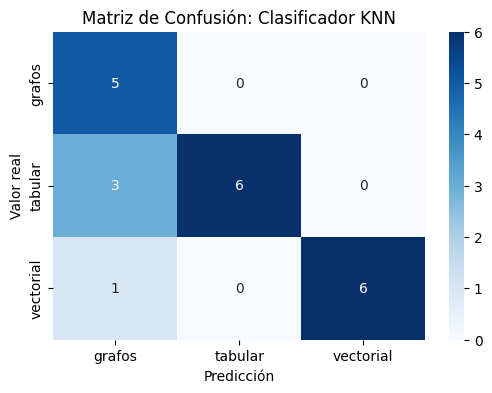

In [ ]:
# Se entrena KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_knn, y_train) # Entrena solo con vectores de train

# Se obtienen las etiquetas
labels = sorted(df_test["clase"].unique())

# Resumen
y_pred_knn = knn.predict(X_test_knn) # Predice usando vectores de test
print(classification_report(y_test, y_pred_knn))

# Matriz de confusión
plt.figure(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred_knn, labels=labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión: Clasificador KNN")
plt.show()

Las métricas muestran que el clasificador alcanza un accuracy global del 81%, lo que indica un desempeño general aceptable considerando la simplicidad del modelo. La clase vectorial presenta el mejor rendimiento, con precisión perfecta (1.00) y un f1-score de 0.92, lo que evidencia una identificación consistente y confiable de este tipo de consultas.

En la categoría tabular, si bien la precisión es alta (1.00), el recall más bajo (0.67) sugiere que el modelo tiende a ser conservador, clasificando correctamente los casos detectados pero dejando algunos sin identificar. Por otro lado, la clase grafos alcanza un recall de 1.00, lo que indica que todas las consultas de este tipo fueron detectadas, aunque con baja precisión (0.56), reflejando la presencia de falsos positivos.

En resumen, los resultados muestran que el modelo es eficaz para capturar ciertas intenciones, pero presenta margen de mejora en la discriminación entre clases semánticamente cercanas.

**LLM con Few-Shot Prompting**

              precision    recall  f1-score   support

      grafos       0.80      0.80      0.80         5
     tabular       0.89      0.89      0.89         9
   vectorial       1.00      1.00      1.00         7

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21



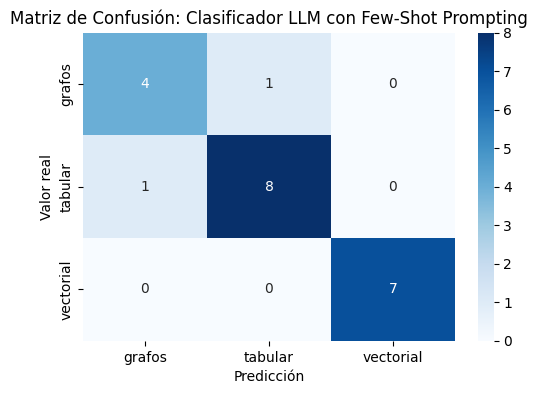

In [ ]:
system_prompt = """
    Eres un experto clasificador de intención...
    Tu trabajo es decidir qué herramienta debe responder la pregunta del usuario.

    Las opciones son:
    1. Vectorial: Para preguntas sobre CÓMO usar algo, manuales, garantías, descripciones de texto o reseñas/opiniones. (Búsqueda semántica).
    2. Tabular: Para datos exactos, precios, stock, estado de tickets, buscar personas/vendedores o cálculos numéricos. (Búsqueda SQL/Pandas).
    3. Grafos: Para recomendaciones, buscar productos compatibles, repuestos, o patrones de conexión entre entidades. (Relaciones).

    EJEMPLOS:
    Usuario: "¿Cómo limpio mi licuadora?" -> Respuesta: Vectorial
    Usuario: "¿Qué opinan de la batidora?" -> Respuesta: Vectorial
    Usuario: "Manual de la plancha" -> Respuesta: Vectorial

    Usuario: "¿Cuánto vendió Juan ayer?" -> Respuesta: Tabular
    Usuario: "Precio del Smart TV" -> Respuesta: Tabular
    Usuario: "Estado del ticket TKT001" -> Respuesta: Tabular

    Usuario: "Recomendame algo parecido a esto" -> Respuesta: Grafos
    Usuario: "¿Qué repuesto va con este motor?" -> Respuesta: Grafos
    Usuario: "¿Qué suelen comprar junto con la cafetera?" -> Respuesta: Grafos

    Responde SOLAMENTE con una de las tres palabras: Vectorial, Tabular o Grafos
"""

def clf_llm_seguro(query):
    try:
        prompt = system_prompt + '\n\n' + query
        respuesta = model.complete(prompt)
        # Limpieza simple para asegurar que coincida con las etiquetas
        return respuesta.text.strip().replace(".", "").lower()
    except:
        return "ERROR"

y_pred_llm = []

# Iteramos sobre los textos de test
for i, query in enumerate(X_test_llm):
    pred = clf_llm_seguro(query)
    y_pred_llm.append(pred)
    time.sleep(1)

# Resumen, si el LLM devuelve "ERROR", el reporte lo mostrará como una clase extra
print(classification_report(y_test, y_pred_llm))

# Matriz de confusión
plt.figure(figsize=(6,4))
cm2 = confusion_matrix(y_test, y_pred_llm, labels=labels)
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión: Clasificador LLM con Few-Shot Prompting")
plt.show()

Las métricas indican un desempeño general sólido, con un accuracy del 90%, lo que refleja una alta capacidad del modelo para clasificar correctamente la intención de las consultas. A diferencia de KNN, el rendimiento es consistente entre todas las clases, sin caídas marcadas en precisión o recall.

La clase vectorial alcanza un desempeño perfecto (precision, recall y f1-score de 1.00), evidenciando una identificación totalmente confiable. Las categorías grafos y tabular presentan valores equilibrados de precisión y recall (0.80 y 0.89 respectivamente), lo que indica una buena capacidad tanto para detectar correctamente las consultas como para evitar clasificaciones erróneas.

La igualdad entre el macro average y el weighted average (0.90) sugiere un comportamiento balanceado del modelo, sin sesgos significativos hacia clases con mayor cantidad de ejemplos. En conjunto, estos resultados muestran un modelo robusto y estable para la clasificación de intenciones.

Sin embargo, a pesar de la superioridad métrica del LLM, se optó por utilizar el algoritmo KNN para clasificar las intenciones. Esta decisión se basa en minimizar el consumo de tokens, sacrificando el margen de robustez del LLM a costa de obtener un modelo más rápido, eficiente y escalable. Dado que el modelo de embeddings ya proporciona una representación semántica rica, KNN logra explotar directamente las distancias en el espacio vectorial sin necesidad de un procesamiento generativo costoso, manteniéndose como una opción altamente competitiva y confiable para la clasificación de intenciones en producción.


## Pipeline de Recuperación (Retrieval)

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
class Reranker:
    """
    Implementación del Reranker usando un modelo Cross-Encoder (Sentence Transformers).
    """

    def __init__(self, model_name: str = 'cross-encoder/ms-marco-MiniLM-L-6-v2'):
        """
        Inicializa el reranker cargando un modelo Cross-Encoder.

        Args:
            model_name: Modelo optimizado para re-ranking. El MiniLM es eficiente y multilingüe.
        """
        self.model = CrossEncoder(model_name)
        self.model_name = model_name

    def rerank(self, query: str, nodes: List[NodeWithScore], top_k: int = None) -> List[NodeWithScore]:
        """
        Reordena los nodos recuperados (de la Búsqueda Híbrida) usando el Cross-Encoder.

        Args:
            query: Consulta original del usuario.
            nodes: Lista de NodeWithScore (chunks) a reordenar.
            top_k: Número final de nodos a devolver.

        Returns:
            Lista de NodeWithScore reordenada y truncada al top_k.
        """
        if not nodes:
            return nodes

        # Se crean pares (pregunta, chunk_texto)
        pairs = [(query, node.node.text) for node in nodes]

        # Se predicen y asignan los scores de relevancia a los nodos
        scores = self.model.predict(pairs)

        scored_nodes = []
        for i, node_with_score in enumerate(nodes):
            new_score = scores[i].item()
            node_with_score.score = new_score
            scored_nodes.append(node_with_score)

        # Se ordena de acuerdo al Reranker
        scored_nodes.sort(key=lambda x: x.score, reverse=True)

        if top_k:
            return scored_nodes[:top_k]

        return scored_nodes

reranker = Reranker()

In [ ]:
# Se indexan los documentos
llama_documents = []
for chunk_data in todos_los_chunks:
    llama_doc = Document(text=chunk_data['text'], metadata=chunk_data['metadata'], id_=chunk_data['id'])
    llama_documents.append(llama_doc)

# Se crea el índice vectorial
index = VectorStoreIndex.from_documents(llama_documents, show_progress=True)

# Retriever BM25
retriever_bm25 = BM25Retriever.from_defaults(index=index,similarity_top_k=5)

# Retriever vectorial
retriever_vectorial = VectorIndexRetriever(index, similarity_top_k=10)

# Fusion RRF
retriever_fusion = QueryFusionRetriever(
    retrievers=[retriever_vectorial, retriever_bm25],
    similarity_top_k=20,
    num_queries=3,
    use_async=False,
    verbose=False
)

# ReRanker
reranker_co = SentenceTransformerRerank(model="cross-encoder/ms-marco-MiniLM-L-2-v2", top_n=10)

Parsing nodes:   0%|          | 0/13997 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/1709 [00:00<?, ?it/s]

DEBUG:bm25s:Building index from IDs objects


In [ ]:
def retriever_hibrido_final_llamaindex(query_str: str) -> List[NodeWithScore]:
    """
    Implementa el Pipeline de Recuperación Híbrida + ReRank usando LlamaIndex.
    """

    # Búsqueda Híbrida
    all_nodes_fused = retriever_fusion.retrieve(query_str)

    # ReRank
    final_nodes = reranker_co.postprocess_nodes(all_nodes_fused, query_bundle=QueryBundle(query_str))

    return final_nodes

In [ ]:
retriever_vectorial_final = lambda prompt: retriever_hibrido_final_llamaindex(query_str=prompt)

mis_retrivers = {
    "vectorial": retriever_vectorial_final,
    "tabular": busqueda_tabular,
    "grafos": busqueda_grafos
}

def query_pipeline(prompt, knn_classifier, retrievers_dict, top_k=5):
    """
    Función de orquestación que dirige la consulta a la fuente correcta.
    """

    # Clasificar intención
    prompt_embedding = embed([prompt])[0]
    tipo = knn_classifier.predict([prompt_embedding])[0]

    # Recuperación según tipo
    if tipo == "vectorial" and "vectorial" in retrievers_dict:
        resultados = retrievers_dict["vectorial"](prompt)
        return "VECTORIAL", resultados

    elif tipo == "tabular" and "tabular" in retrievers_dict:
        resultados = retrievers_dict["tabular"](df_maestro, prompt)
        return "TABULAR", resultados

    elif tipo == "grafos" and "grafos" in retrievers_dict:
        resultados = retrievers_dict["grafos"](prompt)
        return "GRAFOS", resultados

    else:
        return "FALLO", f"No se encontró un manejador para la intención {tipo.upper()}"

In [ ]:
query_pipeline("¿Cuáles son las licuadoras de más de $200?", knn, mis_retrivers)

('GRAFOS',
                nombre id_producto
 0           licuadora       P0001
 1           licuadora       P0002
 2  plus licuadora pro       P0003
 3  compacto licuadora       P0004
 4           licuadora       P0005
 5           licuadora       P0006
 6           licuadora       P0007
 7     ultra licuadora       P0008)

In [ ]:
query_pipeline("Cómo reiniciar el dispositivo", knn, mis_retrivers)

('VECTORIAL',
 [NodeWithScore(node=TextNode(id_='d6c7f222-cb0c-44a5-aae1-e51e4bc23958', embedding=None, metadata={'id_faq': 'FAQ00044', 'id_producto': 'P0005', 'nombre_producto': 'Licuadora', 'categoria': 'Uso', 'pregunta': '¿Cómo se usa correctamente este producto?', 'respuesta': 'El Licuadora de HomeChef está diseñado para uso doméstico. Revise el manual del producto (código P0005) para más detalles. Ante cualquier duda, contacte a nuestro servicio de atención al cliente.', 'fecha_publicacion': '2025-02-06', 'vistas': 1898, 'util': 11, 'filename': 'faqs.json', 'source_type': 'faqs'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='FAQ00044', node_type='4', metadata={'id_faq': 'FAQ00044', 'id_producto': 'P0005', 'nombre_producto': 'Licuadora', 'categoria': 'Uso', 'pregunta': '¿Cómo se usa correctamente este producto?', 'respuesta': 'El Licuadora de HomeChef está diseñado para uso doméstico. Revise 

In [ ]:
query_pipeline("Dime el nombre del los productos que pertencen a la subcategoria de pequeños electrodomésticos", knn, mis_retrivers)

('GRAFOS',
                        nombre id_producto
 0        deluxe cafetera 2024       P0120
 1            premium cafetera       P0121
 2                    cafetera       P0122
 3              pava eléctrica       P0123
 4         pava eléctrica 2024       P0124
 5          max pava eléctrica       P0125
 6   turbo pava eléctrica 2024       P0126
 7              pava eléctrica       P0127
 8     advanced pava eléctrica       P0128
 9             exprimidor 2024       P0129
 10        deluxe exprimidor x       P0130
 11           turbo exprimidor       P0131
 12                 exprimidor       P0132
 13                 exprimidor       P0133
 14                  yogurtera       P0134
 15      profesional yogurtera       P0135
 16            smart yogurtera       P0136
 17                  yogurtera       P0137
 18         advanced yogurtera       P0138
 19      deluxe yogurtera 3000       P0139
 20                  yogurtera       P0140
 21     advanced deshidratador       P0141


## Generación y Conversación

In [ ]:
class MemoriaConversacional:
    def __init__(self, max_history=5):
        self.historial = deque(maxlen=max_history)

    def agregar(self, usuario, asistente):
        self.historial.append((usuario, asistente))

    def obtener_contexto_formateado(self):
        """Convierte el historial en un string para el prompt del LLM"""
        if not self.historial:
            return ""

        texto_historial = "--- HISTORIAL DE CONVERSACIÓN PREVIA ---\n"
        for u, a in self.historial:
            texto_historial += f"Usuario: {u}\nAsistente: {a}\n"
        texto_historial += "----------------------------------------\n"
        return texto_historial

In [ ]:
def generar_respuesta_final_chat(llm, prompt_usuario, contexto_retrieved, memoria_str):
    instrucciones = (
        "Eres un asistente virtual de atención al cliente, amable y profesional.\n\n"
        "REGLA CRÍTICA DE IDIOMA:\n"
        "- DEBES responder SIEMPRE en el MISMO idioma en el que esté escrita la pregunta del usuario.\n"
        "- Si el usuario escribe en inglés, responde en inglés.\n"
        "- Si el usuario escribe en español, responde en español.\n"
        "- NO aclares ni menciones que estás detectando el idioma.\n\n"
        "TU OBJETIVO:\n"
        "Responder la pregunta del usuario basándote ÚNICAMENTE en la INFORMACIÓN RECUPERADA.\n\n"
        "INSTRUCCIONES:\n"
        "1. Usa el HISTORIAL DE CONVERSACIÓN solo para entender el contexto, no para inventar información.\n"
        "2. Si la INFORMACIÓN RECUPERADA responde la pregunta, utilízala para redactar la respuesta.\n"
        "3. Si la INFORMACIÓN RECUPERADA está vacía o indica que no se encontró información,\n"
        "   DEBES informar amablemente que no cuentas con esa información y sugerir que reformule la consulta.\n"
        "4. Usa la información EXACTAMENTE como aparece en el contexto; NO inventes datos ni relaciones.\n"
        "5. Si hay datos de productos, incluye nombre, categoría, subcategoría, marca, precio\n"
        "   y cualquier descripción disponible.\n"
        "6. Si la pregunta implica una comparación entre productos, resalta diferencias\n"
        "   SOLO en base a la información disponible."
    )


    prompt_completo = (
        f"{instrucciones}\n\n"
        f"{memoria_str}\n\n"
        f"--- INFORMACIÓN RECUPERADA DEL SISTEMA ---\n"
        f"{contexto_retrieved}\n"
        f"------------------------------------------\n\n"
        f"Usuario: {prompt_usuario}\n"
        f"Asistente:"
    )

    respuesta = llm.complete(prompt_completo)
    return str(respuesta)

In [ ]:
class AgenteAtencionCliente:
    def __init__(self, pipeline_func, retrievers, clasificador, llm):
        self.memoria = MemoriaConversacional(max_history=5)
        self.pipeline = pipeline_func
        self.retrievers = retrievers
        self.clasificador = clasificador
        self.llm = llm

    def chatear(self, mensaje_usuario):
        # Recuperar Contexto del Historial
        historial_str = self.memoria.obtener_contexto_formateado()

        # Ejecutar el Pipeline
        tipo_detectado, resultado_pipeline = self.pipeline(
            mensaje_usuario,
            self.clasificador,
            self.retrievers
        )

        info_recuperada = ""

        # Caso A: El resultado es un DataFrame (Tabular)
        if isinstance(resultado_pipeline, pd.DataFrame):
            if resultado_pipeline.empty:
                info_recuperada = "No se encontraron datos en la tabla."
            else:
                # Convertimos la tabla a texto Markdown para que el LLM la entienda
                info_recuperada = f"Datos encontrados:\n{resultado_pipeline.to_markdown(index=False)}"

        # Caso B: El resultado ya es texto (Vectorial / Grafos / String simple)
        elif isinstance(resultado_pipeline, str):
            info_recuperada = resultado_pipeline

        # Caso C: Lista de Nodos de LlamaIndex (Vectorial crudo)
        elif isinstance(resultado_pipeline, list):
             # Extraemos el texto de los nodos si viene crudo
             info_recuperada = "\n".join([n.node.text for n in resultado_pipeline if hasattr(n, 'node')])

        # Caso D: Fallo o Vacío
        else:
            info_recuperada = "No se encontró información relevante."

        # Validar si realmente tenemos info útil para el prompt
        if tipo_detectado == "FALLO" or not info_recuperada:
            texto_contexto = "No se encontró información interna."
        else:
            texto_contexto = f"Fuente ({tipo_detectado}):\n{info_recuperada}"

        # Generación Final (RAG Conversacional)
        respuesta_final = generar_respuesta_final_chat(
            self.llm,
            mensaje_usuario,
            texto_contexto,
            historial_str
        )

        # Guardar en memoria
        self.memoria.agregar(mensaje_usuario, respuesta_final)

        return respuesta_final

# Bucle de conversación
def iniciar_chat():
    print("¡Hola! Soy tu asistente virtual. Pregúntame sobre productos, manuales o inventario.")
    print("       (Escribe 'salir' para terminar)\n")

    while True:
        user_input = input("Tú: ")
        if user_input.lower() in ["salir", "exit", "chau"]:
            print("¡Hasta luego!")
            break

        # El agente procesa todo
        respuesta = bot.chatear(user_input)

        print(f"{respuesta}\n")

In [ ]:
bot = AgenteAtencionCliente(pipeline_func=query_pipeline, retrievers=mis_retrivers, clasificador=knn, llm=Settings.llm)

# Ejecutar
iniciar_chat()

¡Hola! Soy tu asistente virtual. Pregúntame sobre productos, manuales o inventario.
       (Escribe 'salir' para terminar)

Tú: Cual fue la venta cuyo precio total sea el mas alto ?
La venta con el precio total más alto fue la de Aire Split, con un total de 8650.6.


Tú: Dime el nombre de ese cliente ?
No cuento con la información del cliente que realizó la compra de Aire Split con el precio total más alto. ¿Te gustaría que reformules la consulta?


Tú: Cual es el motivo más repetido por cual se realiza una devolución ?
El motivo más repetido por el cual se realiza una devolución es "Compra equivocada", con una cantidad de 345.


Tú: Como puedo usar una Picadora Premium ?
Para usar la Premium Picadora, sigue estos pasos:

1.  Verifica que el aparato esté correctamente ensamblado.
2.  Conecta a un tomacorriente con conexión a tierra.
3.  Prepara los ingredientes o materiales según necesidad.
4.  Coloca los ingredientes en el recipiente correspondiente.
5.  Cierra la tapa o puerta de seg

# Ejercicio 2

In [ ]:
# Configuración del LLM para el Agente
llm_agent = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

**Creación de las Herramientas**

In [ ]:
@tool
def doc_search(query: str) -> str:
    """
    Útil para buscar información cualitativa en manuales y reseñas.
    """
    nodes = retriever_vectorial.retrieve(query)

    nodes = reranker_co.postprocess_nodes(nodes, query_bundle=QueryBundle(query))

    if not nodes:
        return "No se encontró información en los documentos."

    contexto = "\n\n".join([n.node.text for n in nodes[:3]])
    return contexto


@tool
def table_search(query: str) -> str:
    """
    Útil para buscar datos cuantitativos exactos: precios, stock, códigos de producto,
    estado de tickets, devoluciones o información de inventario.
    Usa la base de datos maestra de productos.
    """
    return busqueda_tabular(df_maestro, query)

@tool
def graph_search(query: str) -> str:
    """
    Útil para consultas sobre relaciones: productos compatibles, recomendaciones
    basadas en compras previas, repuestos necesarios o qué compran otros usuarios.
    """
    return busqueda_grafos(query)

@tool
def analytics_tool(query: str) -> str:
    """
    Genera un gráfico a partir de df_maestro según la consulta del usuario
    y lo guarda en un archivo de imagen.
    """
    try:
        columns_info = ", ".join(df_maestro.columns)

        code_prompt = (
            f"Tienes un dataframe de pandas llamado 'df_maestro'. Columnas: {columns_info}.\n"
            f"El usuario quiere: '{query}'.\n"
            "Escribe código Python usando matplotlib.pyplot para generar el gráfico.\n"
            "Reglas:\n"
            "1. NO crees datos falsos, usa df_maestro.\n"
            "2. Usa plt.figure(figsize=(10,6)).\n"
            "3. Al final, usa plt.savefig('grafico_generado.png') y plt.close().\n"
            "4. Devuelve SOLAMENTE el código Python."
        )

        response = llm_agent.invoke(code_prompt)
        code = response.content

        if "```" in code:
            code = code.split("```")[1]
            if code.startswith("python"):
                code = code[len("python"):]

        code = code.strip()

        import matplotlib
        matplotlib.use("Agg")

        local_context = {"df_maestro": df_maestro, "plt": plt, "pd": pd}
        exec(code, {}, local_context)

        return "Gráfico generado exitosamente y guardado como 'grafico_generado.png'."

    except Exception as e:
        return f"Error generando el gráfico: {str(e)}"


mis_tools = [doc_search, table_search, graph_search, analytics_tool]

**Creación del prompt**

In [ ]:
template_react = """
Eres un Asistente Inteligente de una tienda de electrodomésticos.

REGLA FUNDAMENTAL DE IDIOMA:
- Debes responder SIEMPRE en el mismo idioma en el que está escrita la pregunta del usuario.
- No aclares que estás detectando el idioma.

TU OBJETIVO:
Responder correctamente usando UNA herramienta adecuada, según el tipo de información solicitada.
NO generes gráficos ni archivos a menos que el usuario lo pida explícitamente.

HERRAMIENTAS DISPONIBLES Y CUÁNDO USAR CADA UNA:

{tools}

Los nombres de las herramientas disponibles son: {tool_names}

1) doc_search
ÚSALA CUANDO:
- El usuario pide información cualitativa, descriptiva o explicativa.
- Información proveniente de manuales, reseñas o documentos.
Ejemplos:
- “¿Qué dice el manual de la licuadora X?”
- “Características del producto Y”
- “Cómo funciona el producto Z”

NO usarla para:
- Precios
- Stock
- Rankings
- Relaciones entre clientes y productos

2) table_search
ÚSALA CUANDO:
- El usuario pide datos cuantitativos exactos que están en la base de productos.
Ejemplos:
- Precios
- Stock
- Códigos de producto
- Estado de inventario
- Devoluciones
- Listados de productos con valores numéricos

NO usarla para:
- Relaciones entre entidades
- Recomendaciones
- Rankings complejos entre clientes

3) graph_search
ÚSALA CUANDO:
- El usuario pregunta por relaciones entre entidades.
- Rankings, jerarquías o conexiones entre clientes, productos o compras.
Ejemplos:
- “¿Quién es el mejor cliente?”
- “Cliente que más compras realizó”
- “Qué productos compra este cliente”
- “Qué compran otros usuarios”
- “Recomendaciones basadas en compras previas”
- “Productos relacionados o compatibles”

4) analytics_tool
ÚSALA EXCLUSIVAMENTE CUANDO:
- El usuario PIDE EXPLÍCITAMENTE un gráfico, visualización, plot, diagrama o imagen.
Ejemplos:
- “Mostrame un gráfico de ventas”
- “Graficá el stock por categoría”
- “Visualizá las ventas”

NO usarla cuando:
- El usuario solo pide un dato, nombre, ranking o resultado textual,
  incluso si ese resultado surge de un análisis numérico.

REGLAS CRÍTICAS:
- NUNCA generes gráficos si el usuario no los pidió explícitamente.
- NUNCA respondas “ver el gráfico” si el usuario no solicitó uno.
- Si la respuesta puede darse como texto → responde con texto.
- Usa SOLO UNA herramienta por consulta, salvo que sea estrictamente necesario.
- Si ninguna herramienta es necesaria, responde directamente.

FORMATO OBLIGATORIO (NO CAMBIAR PALABRAS CLAVE):

Question: pregunta del usuario
Thought: razonamiento interno (breve)
Action: nombre exacto de la herramienta (o vacío si no se usa)
Action Input: entrada para la herramienta
Observation: resultado de la herramienta
...(puede repetirse)
Thought: ya tengo la información necesaria
Final Answer: respuesta final al usuario en el MISMO idioma de la Question

RESTRICCIONES DE FORMATO:
- NO uses markdown.
- NO uses bloques de código.
- NO traduzcas las palabras Thought, Action, Action Input, Observation, Final Answer.

Question: {input}
Thought:{agent_scratchpad}
"""

prompt_react = PromptTemplate.from_template(template_react)

**Creación del agente y su interfaz de consulta**

In [ ]:
agent = create_react_agent(llm=llm_agent, tools=mis_tools, prompt=prompt_react)

agent_executor = AgentExecutor(
    agent=agent,
    tools=mis_tools,
    verbose=False,
    handle_parsing_errors=True,
    max_iterations=2
)

class AgenteAtencionCliente:
    def __init__(self, agent_executor):
        """
        Agente de atención basado en LangChain ReAct.
        """
        self.agent_executor = agent_executor

    def chatear(self, mensaje_usuario: str) -> str:
        """
        Envía la consulta al agente y devuelve la respuesta.
        """
        try:
            resultado = self.agent_executor.invoke({"input": mensaje_usuario})
            return resultado.get("output", "No pude generar una respuesta.")
        except Exception as e:
            return f"Ocurrió un error procesando tu consulta: {str(e)}"

    def iniciar_chat(self):
        """
        Loop de conversación por consola.
        """
        print("¡Hola! Soy tu asistente virtual.")
        print("Puedo ayudarte con productos, manuales, inventario, relaciones y gráficos.")
        print("(Escribe 'salir' para terminar)\n")

        while True:
            user_input = input("Tú: ")

            if user_input.lower() in ["salir", "exit", "chau"]:
                print("¡Hasta luego!")
                break

            respuesta = self.chatear(user_input)
            print(f"\nAGENTE: {respuesta}\n")

In [ ]:
bot2 = AgenteAtencionCliente(agent_executor)
bot2.iniciar_chat()

¡Hola! Soy tu asistente virtual.
Puedo ayudarte con productos, manuales, inventario, relaciones y gráficos.
(Escribe 'salir' para terminar)

Tú: What is the best-selling product?

AGENTE: The best-selling product is waflera (P0070) with a total quantity of 396.

Tú: Which region generated the most sales?

AGENTE: The region that generated the most sales is jujuy.

Tú:  How many branches do we have there?

AGENTE: Agent stopped due to iteration limit or time limit.



KeyboardInterrupt: Interrupted by user